# MODELOS PARA LAS PREDICCIONES DE CANCELACIÓN

In [1]:
import pandas as pd
import os
from scipy.sparse import load_npz
import numpy as np
import chardet
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix, hstack

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score
)
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.sparse import hstack, csr_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.combine import SMOTETomek

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve)

from joblib import dump, load
import os
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap

#### CARGAMOS EL SCRIPT CON LAS FUNCIONES DEL MODELADO y LIMPIEZA
import Funciones_limpieza as lmp
import Funciones_modelado as fm


Definimos paleta de colores

In [2]:
# Paleta
palette_hospitality = [
    "#1F3C4B", "#2C6E91", "#6B8E23", "#4F7C6B",
    "#E6D5B8", "#D8CFC4", "#C97C5D", "#C9A24D",
    "#4A4A4A", "#9E9E9E", "#F7F4EF", "#1C1C1C",
    "#8B3A3A",  # rojo apagado
    "#6F8F72"   # verde oliva suave
]

# Tema base Seaborn (afecta también a matplotlib)
sns.set_theme(
    style="whitegrid",
    palette=palette_hospitality,
    rc={
        # Tamaño de figuras
        "figure.figsize": (10, 6),

        # Títulos y labels
        "axes.titlesize": 14,
        "axes.labelsize": 12,

        # Líneas
        "lines.linewidth": 2,

        # Grid
        "grid.alpha": 0.3,

        # Tipografía
        "font.size": 11
    }
)

# Asegurar que matplotlib use exactamente la misma paleta
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_hospitality)


### Cargamos datos del modelado y de las variables metereologicas

In [3]:
# df con concidiciones metereologicas
ruta_csv_metereologico = os.path.join("..", "Datos", "DatosTransformados", "df_metereologico_modelado.csv")

# para saber como cargar el csv
with open(ruta_csv_metereologico, "rb") as f:
    rawdata = f.read(10000)  # lee los primeros bytes
    result = chardet.detect(rawdata)
    print(result)
ruta_csv_metereologico = os.path.join("..", "Datos", "DatosTransformados", "df_metereologico_modelado.csv")

# ===============================
# Cargar CSV con codificación correcta
# ===============================
df_metereologico = pd.read_csv(ruta_csv_metereologico, encoding="ISO-8859-1",true_values=['yes'], false_values=['no'],
    decimal='.', sep=',', thousands=',')


ruta_csv_clusters = os.path.join("..", "Datos", "Resultados", "df_con_clusters_asignados.csv")
df_con_clusters = pd.read_csv(ruta_csv_clusters,true_values=['yes'], false_values=['no'],
    decimal='.', sep=',', thousands=',')




{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


Juntamos las columnas metereologicas con las del cluster, eligiendo las metereologicas que nos interesan

In [4]:
df_metereologico.columns

Index(['booked_at', 'checkin_time', 'checkout_time', 'lead_time',
       'lenght_of_stay', 'checkin_month', 'checkin_day', 'adult_count',
       'child_count', 'origin', 'travel_agency_name', 'requested_category',
       'requested_category_name', 'asset', 'asset_type', 'asset_opening_date',
       'available_units', 'business_segment', 'rate', 'rate_group_name',
       'rate_type', 'completed_entry_forms_count', 'all_entry_forms_completed',
       'returning_inhabitant', 'recurrence', 'libere_community',
       'bought_products', 'product_count', 'reservation_net_value',
       'total_adr', 'status', 'cancellation_reason', 'cancellation_lead_time',
       'ha_cancelado', 'momento_checkin', 'ratio_asistencia',
       'ratio_cancelaciones_mes_respecto_reservas', 'zona_roja',
       'estacion_estancia', 'estacion_reserva', 'antiguedad_hotel_en_dias',
       'es_festivo', 'es_finde', 'city', 'checkin_date', 'checkout_date',
       'invalid_interval', 'altitud', 'tmed', 'prec', 'tmin', 'tm

Utilizaremos estas columnas (no vamos a añadir las especificas)

In [5]:
cols_meteorologia = [
    'tmed',    # temperatura media
    'tmin',    # mínima
    'tmax',    # máxima
    'prec',    # precipitación
    'sol',     # horas de sol
]


Miramos si hay duplicados en la tempertura cuando el dia y la fecha es distinta 

In [6]:
cols_clima = ['tmed', 'tmin', 'tmax', 'prec', 'sol']

dup_clima = df_metereologico[df_metereologico.duplicated(subset=cols_clima, keep=False)]


resultado = (
    df_metereologico[df_metereologico.duplicated(subset=cols_clima, keep=False)]
    .groupby(cols_clima)
    .filter(
        lambda x: x['checkin_time'].nunique() > 1
                  and x['city'].nunique() > 1
    )
)
resultado[[ 'tmed',    # temperatura media
    'tmin',    # mínima
    'tmax',    # máxima
    'prec',    # precipitación
    'sol','checkin_time', 'city']] 


# NO HAY POR LO QUE LOS DATOS ESTAN BIEN

,tmed,tmin,tmax,prec,sol,checkin_time,city


Juntamos las variables de metereologicas con el df con los clusteres

In [7]:
df_meteo_limpio = df_metereologico.dropna(subset=cols_meteorologia)


In [8]:
df_clusters_alineado = df_con_clusters.loc[df_meteo_limpio.index]



In [9]:
df_final = pd.concat(
    [df_clusters_alineado, df_meteo_limpio[cols_meteorologia]],
    axis=1
)
df_final

,booked_at,checkin_time,checkout_time,lead_time,lenght_of_stay,checkin_month,checkin_day,adult_count,child_count,origin,...,antiguedad_hotel_en_dias,es_festivo,es_finde,city,clusters,tmed,tmin,tmax,prec,sol
0,2022-11-26 16:10:00,2023-01-01 12:00:00,2023-01-02 12:00:00,36,1,January,Sunday,1,0,channel_manager,...,2123,False,False,Donostia,3,16.750000,10.3,24.6,0.950000,3.150000
1,2022-12-21 17:27:00,2023-01-01 13:09:00,2023-01-10 12:00:00,11,9,January,Sunday,1,0,channel_manager,...,2123,True,False,Donostia,3,13.020000,5.6,24.6,6.790000,3.790000
2,2022-09-21 19:46:00,2023-01-01 15:00:00,2023-01-07 12:00:00,102,6,January,Sunday,2,4,channel_manager,...,2123,True,False,Donostia,3,13.114286,5.6,24.6,1.514286,4.357143
3,2022-09-24 12:09:00,2023-01-01 15:00:00,2023-01-02 12:00:00,99,1,January,Sunday,2,2,channel_manager,...,2123,False,False,Donostia,3,16.750000,10.3,24.6,0.950000,3.150000
4,2022-10-18 07:12:00,2023-01-01 15:00:00,2023-01-02 12:00:00,75,1,January,Sunday,4,0,channel_manager,...,2123,False,False,Donostia,3,16.750000,10.3,24.6,0.950000,3.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52094,2023-11-09 13:58:00,2023-11-14 15:00:00,2023-11-17 11:00:00,5,3,November,Tuesday,1,0,email,...,1211,False,False,Pamplona,0,7.500000,2.0,12.2,0.100000,4.250000
52095,2023-11-10 12:59:00,2023-11-14 15:00:00,2023-11-16 11:00:00,4,2,November,Tuesday,1,0,channel_manager,...,1211,False,False,Pamplona,0,7.500000,2.0,12.2,0.100000,4.250000
52096,2023-11-07 11:39:00,2023-11-15 14:16:00,2023-11-16 11:00:00,8,1,November,Wednesday,4,0,channel_manager,...,1211,False,False,Pamplona,0,7.500000,2.0,12.2,0.100000,4.250000
52097,2023-11-13 20:25:00,2023-11-15 15:00:00,2023-11-16 14:00:00,2,1,November,Wednesday,1,0,direct_channel,...,1211,False,False,Pamplona,0,7.500000,2.0,12.2,0.100000,4.250000


### SELECCIONAMOS LAS VARIABLES

Solo vamos a seleccionar las variables que no dan pistas para el target (cancelar/ no cancelar) y clusters vamos a pasar a dummy directamente

In [10]:
df_final.columns

Index(['booked_at', 'checkin_time', 'checkout_time', 'lead_time',
       'lenght_of_stay', 'checkin_month', 'checkin_day', 'adult_count',
       'child_count', 'origin', 'travel_agency_name', 'requested_category',
       'requested_category_name', 'asset', 'asset_type', 'asset_opening_date',
       'available_units', 'business_segment', 'rate', 'rate_group_name',
       'rate_type', 'completed_entry_forms_count', 'all_entry_forms_completed',
       'returning_inhabitant', 'recurrence', 'libere_community',
       'bought_products', 'product_count', 'reservation_net_value',
       'total_adr', 'status', 'cancellation_reason', 'cancellation_lead_time',
       'ha_cancelado', 'momento_checkin', 'ratio_asistencia',
       'ratio_cancelaciones_mes_respecto_reservas', 'zona_roja',
       'estacion_estancia', 'estacion_reserva', 'antiguedad_hotel_en_dias',
       'es_festivo', 'es_finde', 'city', 'clusters', 'tmed', 'tmin', 'tmax',
       'prec', 'sol'],
      dtype='object')

In [11]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore'
)

clusters_ohe = ohe.fit_transform(df_final[['clusters']])

clusters_df = pd.DataFrame(
    clusters_ohe,
    columns=ohe.get_feature_names_out(['clusters']),
    index=df_final.index
)

df_final = pd.concat(
    [df_final.drop(columns=['clusters']), clusters_df],
    axis=1
)



In [12]:
df_final.columns

Index(['booked_at', 'checkin_time', 'checkout_time', 'lead_time',
       'lenght_of_stay', 'checkin_month', 'checkin_day', 'adult_count',
       'child_count', 'origin', 'travel_agency_name', 'requested_category',
       'requested_category_name', 'asset', 'asset_type', 'asset_opening_date',
       'available_units', 'business_segment', 'rate', 'rate_group_name',
       'rate_type', 'completed_entry_forms_count', 'all_entry_forms_completed',
       'returning_inhabitant', 'recurrence', 'libere_community',
       'bought_products', 'product_count', 'reservation_net_value',
       'total_adr', 'status', 'cancellation_reason', 'cancellation_lead_time',
       'ha_cancelado', 'momento_checkin', 'ratio_asistencia',
       'ratio_cancelaciones_mes_respecto_reservas', 'zona_roja',
       'estacion_estancia', 'estacion_reserva', 'antiguedad_hotel_en_dias',
       'es_festivo', 'es_finde', 'city', 'tmed', 'tmin', 'tmax', 'prec', 'sol',
       'clusters_1', 'clusters_2', 'clusters_3'],
      dty

In [13]:
df_final = df_final[['lead_time','lenght_of_stay','checkin_month','checkin_day','adult_count','child_count','origin',
                    'requested_category','asset','asset_type','business_segment','rate_type','returning_inhabitant','recurrence',
                    'libere_community','reservation_net_value',
                    'ratio_cancelaciones_mes_respecto_reservas','zona_roja','estacion_estancia','estacion_reserva','antiguedad_hotel_en_dias','es_festivo',
                    'es_finde','city', 'status','clusters_1', 'clusters_2', 'clusters_3']]

### Utilizando la funcion de limpieza detectamos tipos de columnas

In [14]:
df_final = lmp.detectar_tipos_columnas(df_final)['dataframe_transformado']
num_cols = lmp.detectar_tipos_columnas(df_final)['numericas']
variables_bool = lmp.detectar_tipos_columnas(df_final)['booleanas']
cat_cols = lmp.detectar_tipos_columnas(df_final)['categoricas']
cat_cols.remove('status') 

c:\Users\maita\OneDrive\Escritorio\BDATA 2\RETO 6\CASOS PRACTICOS\RETO06_NARANJA\Scripts\Funciones_limpieza.py:55: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  fechas = pd.to_datetime(serie, errors="coerce", infer_datetime_format=True)
c:\Users\maita\OneDrive\Escritorio\BDATA 2\RETO 6\CASOS PRACTICOS\RETO06_NARANJA\Scripts\Funciones_limpieza.py:55: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fechas = pd.to_datetime(serie, errors="coerce", infer_datetime_format=True)
c:\Users\maita\OneDrive\Escritorio\BDATA 2\RETO 6\CASOS PRACTICOS\RETO06_NARANJA\Scripts\Funciones_limpieza.py:55: UserWarning: The argument 'infer_datetime_format' is

NUMERICAS --> CORRELACION

In [15]:
# definimos target y pasamos a 0/1
target = df_final['status']
# pasamos el target (status) a 0 (no cancelar) o 1 (si cancelar) en ved de checked-out o cancelled
y = target.map({
    "checked_out": 0,
    "cancelled": 1
})
df_final['status'] = df_final['status'].map({
    "checked_out": 0,
    "cancelled": 1
})

In [16]:
target = 'status'
correlacion_numericas = df_final[num_cols + [target]].corr()[target].sort_values(ascending=False).abs().drop(target)
# correlacion_numericas.mean()
# correlacion_numericas[correlacion_numericas>(correlacion_numericas.mean())]
numericas_elegidas = correlacion_numericas.head(4).index.to_list()
numericas_elegidas # cogemos el top 4 

['lead_time', 'adult_count', 'lenght_of_stay', 'reservation_net_value']

In [17]:
# Mirar si hay alta correlacion entre las numericas (para evitar multicolinealidad)
print(df_final[numericas_elegidas].corr()) # Ninguna supera un valor alto, no eliminamos ninguna

                       lead_time  adult_count  lenght_of_stay  \
lead_time               1.000000     0.227879        0.017933   
adult_count             0.227879     1.000000       -0.023905   
lenght_of_stay          0.017933    -0.023905        1.000000   
reservation_net_value   0.045568     0.078929        0.452835   

                       reservation_net_value  
lead_time                           0.045568  
adult_count                         0.078929  
lenght_of_stay                      0.452835  
reservation_net_value               1.000000  


Booleanas

Miramos la diferencia entre si la variable es siendo si o siendo no si ha cancelado o no, es decir, la media de cuando la variable es si cuantas han cancelado y cuantas no y si es significativa significa que la variable si influye al target

In [18]:
for col in variables_bool:
    print(f"\n{col}")
    print(df_final.groupby(col)[target].mean())



returning_inhabitant
returning_inhabitant
False    0.262120
True     0.108508
Name: status, dtype: float64

libere_community
libere_community
False    0.270920
True     0.110602
Name: status, dtype: float64

zona_roja
zona_roja
False    0.238705
True     0.250666
Name: status, dtype: float64

es_festivo
es_festivo
False    0.242911
True     0.248364
Name: status, dtype: float64

es_finde
es_finde
False    0.239188
True     0.256919
Name: status, dtype: float64

clusters_1
clusters_1
False    0.250862
True     0.214057
Name: status, dtype: float64

clusters_2
clusters_2
False    0.248520
True     0.227117
Name: status, dtype: float64

clusters_3
clusters_3
False    0.238877
True     0.265394
Name: status, dtype: float64


In [19]:
# cogeremos un umbral de un 0.02 para considerar significativa la diferencia, ya que en columnas de 0/1 eso es suficiente
binarias_elegidas = []

for var in variables_bool:
    medias = df_final.groupby(var)['status'].mean()
    diff = abs(medias[1] - medias[0])
    if diff > 0.02:
        binarias_elegidas.append(var)

print(binarias_elegidas)


['returning_inhabitant', 'libere_community', 'clusters_1', 'clusters_2', 'clusters_3']


C:\Users\maita\AppData\Local\Temp\ipykernel_71860\1410047699.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = abs(medias[1] - medias[0])


Categoricas

Cancelacion rate por categoria

In [20]:
for col in cat_cols:
    tabla = (
        df_final.groupby(col)[target]
        .mean()
        .sort_values(ascending=False)
    )
    print(f"\n{col}")
    print(tabla.head(10))



checkin_month
checkin_month
June         0.258543
January      0.254282
May          0.247402
February     0.247201
December     0.246772
March        0.244326
September    0.243719
August       0.243499
October      0.242233
July         0.241297
Name: status, dtype: float64

checkin_day
checkin_day
Friday       0.264375
Saturday     0.256368
Sunday       0.252560
Monday       0.247429
Thursday     0.239002
Tuesday      0.222561
Wednesday    0.210180
Name: status, dtype: float64

origin
origin
email              0.345153
telephone          0.312592
in_person          0.302632
channel_manager    0.256992
direct_channel     0.137864
Name: status, dtype: float64

requested_category
requested_category
Three bedroom apartment             0.423611
Three bedroom apartment superior    0.298551
Studio                              0.262951
Two bedroom apartment               0.259085
Two bedroom apartment superior      0.258656
Hostel bed                          0.258363
Studio superior      

In [21]:
cat_elegidas = []

for var in cat_cols:
    medias = df_final.groupby(var)['status'].mean()
    diff = medias.max() - medias.min()
    if diff >= 0.02:
        cat_elegidas.append(var)
cat_elegidas

['checkin_month',
 'checkin_day',
 'origin',
 'requested_category',
 'asset',
 'asset_type',
 'business_segment',
 'rate_type',
 'estacion_reserva',
 'city']

### Elegimos solo las variables significativas

In [22]:
cols_seleccionadas = numericas_elegidas + cat_elegidas + binarias_elegidas

df_modelo = df_final[cols_seleccionadas].copy()
df_modelo.columns

Index(['lead_time', 'adult_count', 'lenght_of_stay', 'reservation_net_value',
       'checkin_month', 'checkin_day', 'origin', 'requested_category', 'asset',
       'asset_type', 'business_segment', 'rate_type', 'estacion_reserva',
       'city', 'returning_inhabitant', 'libere_community', 'clusters_1',
       'clusters_2', 'clusters_3'],
      dtype='object')

# DIVIDIMOS TRAIN/TEST Y ESCALAMOS VARIABLES DUMMIFICAMOS

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df_modelo, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
# Dummificar categóricas
X_train = pd.get_dummies(X_train, columns=cat_elegidas, drop_first=True) # convertimos a dummies en train y luego en test para que no haya data lekage, para que el El modelo no vea información futura y El test represente datos futuros
X_test = pd.get_dummies(X_test, columns=cat_elegidas, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0) 

# Convertir dummies a 0/1
dummy_cols = [c for c in X_train.columns if any(c.startswith(cat) for cat in cat_elegidas)]
X_train[dummy_cols] = X_train[dummy_cols].astype(int)
X_test[dummy_cols] = X_test[dummy_cols].astype(int)


# Escalar numéricas para tener un rango de 0-1 y comparar mejor
scaler = MinMaxScaler()
X_train[numericas_elegidas] = scaler.fit_transform(X_train[numericas_elegidas])
X_test[numericas_elegidas] = scaler.transform(X_test[numericas_elegidas])


In [25]:
X_train

,lead_time,adult_count,lenght_of_stay,reservation_net_value,returning_inhabitant,libere_community,clusters_1,clusters_2,clusters_3,checkin_month_August,...,estacion_reserva_primavera,estacion_reserva_verano,city_Córdoba,city_Donostia,city_Granada,city_Madrid,city_Málaga,city_Pamplona,city_Valencia,city_Vitoria
14953,0.040044,0.111111,0.002049,0.038826,False,False,False,True,False,0,...,1,0,0,0,0,0,0,0,0,1
43616,0.002225,0.000000,0.006148,0.038018,False,False,True,False,False,0,...,0,1,1,0,0,0,0,0,0,0
22233,0.050056,0.111111,0.004098,0.039780,False,False,False,True,False,0,...,0,0,0,0,0,0,0,0,0,1
3576,0.085651,0.000000,0.002049,0.037900,True,False,False,False,True,0,...,1,0,0,1,0,0,0,0,0,0
19368,0.031146,0.333333,0.002049,0.039007,False,False,False,True,False,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,0.003337,0.111111,0.004098,0.038143,False,False,False,False,True,0,...,1,0,0,1,0,0,0,0,0,0
11336,0.001112,0.111111,0.000000,0.037824,False,False,False,True,False,0,...,0,0,0,0,0,0,0,0,0,1
0,0.040044,0.000000,0.000000,0.037548,True,False,False,False,True,0,...,0,0,0,1,0,0,0,0,0,0
19669,0.003337,0.111111,0.002049,0.038243,False,False,False,True,False,0,...,0,0,0,0,0,0,0,0,0,1


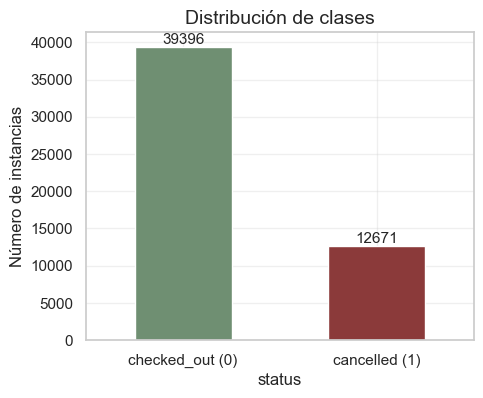

In [26]:
conteo = y.value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(5,4))
conteo.plot(kind='bar', color=[palette_hospitality[13], palette_hospitality[12]])

plt.xticks([0,1], ['checked_out (0)', 'cancelled (1)'], rotation=0)
plt.ylabel('Número de instancias')
plt.title('Distribución de clases')

# Mostrar valores encima de las barras
for i, v in enumerate(conteo):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

Mirar cuantos componenetes debemos de coger para pca

In [27]:
X_train.shape


(41653, 73)

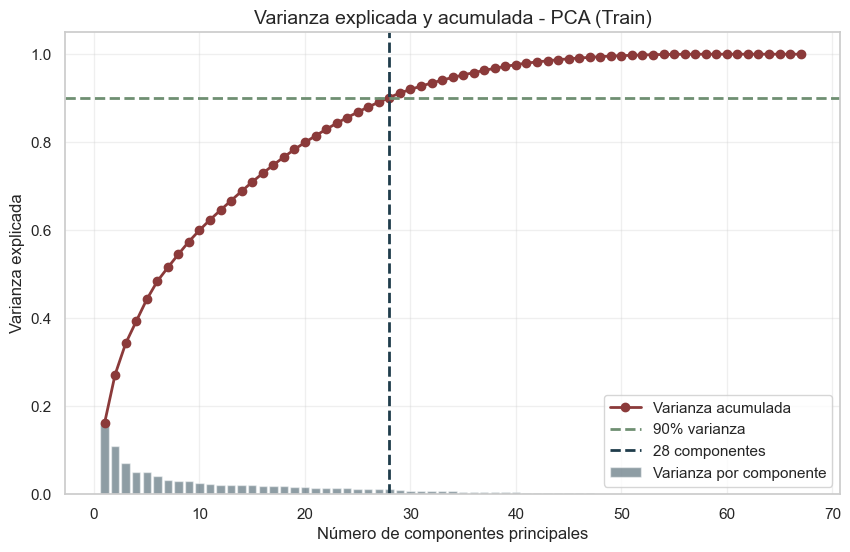

Se necesitan 28 componentes para explicar el 90% de la varianza


In [28]:
# Número máximo de componentes a probar
n_componentes = min(X_train.shape[1], 67)  # no más que columnas disponibles

# Ajustar PCA solo en train
pca = PCA(n_components=n_componentes, random_state=42)
X_train_pca = pca.fit_transform(X_train)

# Varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Número de componentes para explicar el 90% de la varianza
n_90 = np.argmax(cumulative_variance >= 0.9) + 1

# Gráfico
plt.figure(figsize=(10,6))

# Varianza individual
plt.bar(range(1, n_componentes+1), explained_variance, alpha=0.5, label='Varianza por componente')

# Varianza acumulada
plt.plot(range(1, n_componentes+1), cumulative_variance, marker='o', color=palette_hospitality[12], label='Varianza acumulada')

# Línea y marcador en el 90%
plt.axhline(y=0.9, color=palette_hospitality[13], linestyle='--', label='90% varianza')
plt.axvline(x=n_90, color=palette_hospitality[0], linestyle='--', label=f'{n_90} componentes')

plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada')
plt.title('Varianza explicada y acumulada - PCA (Train)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Se necesitan {n_90} componentes para explicar el 90% de la varianza")



Con la funcion definida en funcion modelado dividimos en train y test con y sin datos balanceados para ver si introduce mucho ruido o no (porque ya escalamos valores, hacemos PCA y puede introducir demasiado ruido, pero si hacemos con stratify = y)

CON SMOTE Y PCA

In [29]:

X_train_smote_pca, y_train_smote_pca, pca_obj_smote = fm.preparar_datos(
    X_train, y_train,
    usar_smote=True,
    aplicar_pca=True,
    varianza_objetivo=0.9
)
X_test_pca_smote = pca_obj_smote.transform(X_test)



Shape original: (41653, 73) Shape balanceado con SMOTE: (58578, 73)
PCA aplicado: 29 componentes para explicar 90.0% de varianza


SIN SMOTE PERO CON PCA

In [30]:
X_train_pca, y_train_pca, pca_obj = fm.preparar_datos(
    X_train, y_train,
    usar_smote=False,
    aplicar_pca=True,
    varianza_objetivo=0.9
)
X_test_pca = pca_obj.transform(X_test)

Usando datos sin SMOTE
PCA aplicado: 28 componentes para explicar 90.0% de varianza


C:\Users\maita\AppData\Local\Temp\ipykernel_71860\1099555979.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\maita\AppData\Local\Temp\ipykernel_71860\1099555979.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


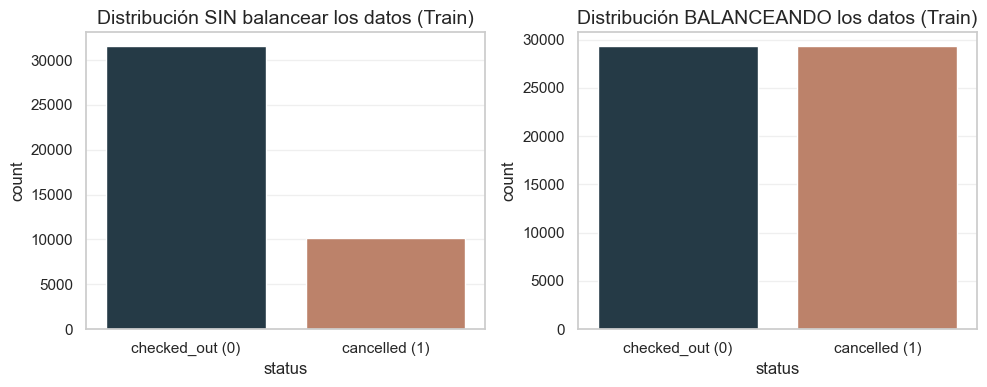

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Paleta específica para la variable objetivo
palette_status = {
    '0': palette_hospitality[0],  # #1F3C4B
    '1': palette_hospitality[6]   # #2C6E91
}

# SIN SMOTE
sns.countplot(
    x=y_train_pca,
    ax=axes[0],
    palette=palette_status,
    order=[0, 1]
)
axes[0].set_title('Distribución SIN balancear los datos (Train)')
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(['checked_out (0)', 'cancelled (1)'])

# CON SMOTE
sns.countplot(
    x=y_train_smote_pca,
    ax=axes[1],
    palette=palette_status,
    order=[0, 1]
)
axes[1].set_title('Distribución BALANCEANDO los datos (Train)')
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(['checked_out (0)', 'cancelled (1)'])

plt.tight_layout()
plt.show()



Tenemos más datos aplicando Smotetomek porque: 
- SMOTE genera nuevas muestras sintéticas de la clase minoritaria para balancear.
- TomekLinks elimina pares cercanos de clases diferentes (normalmente algunos de la clase mayoritaria) para limpiar el borde de decisión.

### MODELOS

Creamos funcion para que encuentre los mejores parametros para los distintos modelos

In [40]:
# ---------------------------------------
# Función para crear pipelines y parámetros
# ---------------------------------------
def crear_pipelines():
    pipelines = {
        "Regresion_Logistica": (
            Pipeline([
                ('clf', LogisticRegression(max_iter=1000))
            ]),
            {
                'clf__C': [0.1, 1]   
            }
        ),

        "Arbol_Decision": (
            Pipeline([
                ('clf', DecisionTreeClassifier(random_state=42))
            ]),
            {
                'clf__max_depth': [5, 10, None]
            }
        ),

        "Naive_Bayes": (
            Pipeline([
                ('clf', GaussianNB())
            ]),
            {
                'clf__var_smoothing': [1e-9]
            }
        ),

        "SVC": (
            Pipeline([
                ('clf', SVC(kernel='linear', probability=True,  class_weight='balanced'))
            ]),
            {
                'clf__C': [0.1, 1]
            }
        ),

        "Random_Forest": (
            Pipeline([
                ('clf', RandomForestClassifier(
                    n_estimators=100,
                    random_state=42,
                    n_jobs=-1
                ))
            ]),
            {
                'clf__max_depth': [10, None]
            }
        )
    }
    return pipelines


Mejores metricas con cross validation con la funcion de modelado

In [41]:
def entrenar_modelos(X_train, y_train, cv=3):
    pipelines = crear_pipelines()
    modelos_entrenados = {}

    for nombre, (pipeline, params) in pipelines.items():
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=params,
            cv=cv,
            n_jobs=-1,
            scoring='recall' # para que eliga los mejores parametros segun recall
        )
        
        grid.fit(X_train, y_train)

        # Guardamos solo el modelo ya entrenado con los mejores parámetros
        modelos_entrenados[nombre] = grid.best_estimator_

    return modelos_entrenados

In [ ]:
modelos_mejores_parametros = entrenar_modelos(X_train_pca, y_train_pca)

In [ ]:
modelos_mejores_parametros
regresion_logistica = modelos_mejores_parametros['Regresion_Logistica']
arbol_decision = modelos_mejores_parametros['Arbol_Decision']
naive_bayes = modelos_mejores_parametros['Naive_Bayes']   
svc = modelos_mejores_parametros['SVC']
random_forest = modelos_mejores_parametros['Random_Forest'] 

In [ ]:
modelos_mejores_parametros_smote = entrenar_modelos(X_train_smote_pca, y_train_smote_pca)

In [ ]:
modelos_mejores_parametros_smote
regresion_logistica_smote = modelos_mejores_parametros_smote['Regresion_Logistica']
arbol_decision_smote = modelos_mejores_parametros_smote['Arbol_Decision']
naive_bayes_smote = modelos_mejores_parametros_smote['Naive_Bayes']
svc_smote = modelos_mejores_parametros_smote['SVC']
random_forest_smote = modelos_mejores_parametros_smote['Random_Forest'] 

Guardamos los modelos para no tener que volver a cargarlos 

In [ ]:
def guardar_modelos(modelos, ruta="Datos/Resultados", sufijo=""):
    """
    Guarda los modelos en la ruta especificada.
    
    Parámetros:
    - modelos: dict, diccionario con clave=nombre del modelo y valor=modelo entrenado.
    - ruta: str, carpeta donde se guardarán los modelos.
    - sufijo: str, sufijo que se agregará al nombre del archivo (ej. "_SMOTE").
    """
    os.makedirs(ruta, exist_ok=True)
    
    for nombre, modelo in modelos.items():
        nombre_archivo = f"{nombre}{sufijo}.joblib"
        dump(modelo, os.path.join(ruta, nombre_archivo))
        print(f"Modelo guardado: {nombre_archivo}")


# Diccionarios con modelos
modelos_normales = {
    'Regresion_Logistica': regresion_logistica,
    'Arbol_Decision': arbol_decision,
    'Naive_Bayes': naive_bayes,
    'SVC': svc,
    'Random_Forest': random_forest
}

modelos_smote = {
    'Regresion_Logistica': regresion_logistica_smote,
    'Arbol_Decision': arbol_decision_smote,
    'Naive_Bayes': naive_bayes_smote,
    'SVC': svc_smote,
    'Random_Forest': random_forest_smote
}





In [ ]:
# Guardar modelos
# guardar_modelos(modelos_normales)           
# guardar_modelos(modelos_smote, sufijo="_SMOTE")  

Modelo guardado: Regresion_Logistica.joblib
Modelo guardado: Arbol_Decision.joblib
Modelo guardado: Naive_Bayes.joblib
Modelo guardado: SVC.joblib
Modelo guardado: Random_Forest.joblib
Modelo guardado: Regresion_Logistica_SMOTE.joblib
Modelo guardado: Arbol_Decision_SMOTE.joblib
Modelo guardado: Naive_Bayes_SMOTE.joblib
Modelo guardado: SVC_SMOTE.joblib
Modelo guardado: Random_Forest_SMOTE.joblib


Cargamos modelos

In [37]:
def cargar_modelos(ruta="Datos/Resultados"):
    modelos = {}
    for archivo in os.listdir(ruta):
        if archivo.endswith(".joblib"):
            nombre = archivo.replace(".joblib", "")
            modelos[nombre] = load(os.path.join(ruta, archivo))
    return modelos


In [ ]:
# modelos_cargados = cargar_modelos()

# svc = modelos_cargados['SVC']
# random_forest = modelos_cargados['Random_Forest']
# arbol_decision = modelos_cargados['Arbol_Decision']
# regresion_logistica = modelos_cargados['Regresion_Logistica']
# Naive_bayes = modelos_cargados['Naive_Bayes']


# svc_smote = modelos_cargados['SVC_SMOTE']
# random_forest_smote = modelos_cargados['Random_Forest_SMOTE']
# arbol_decision_smote = modelos_cargados['Arbol_Decision_SMOTE']
# regresion_logistica_smote = modelos_cargados['Regresion_Logistica_SMOTE']
# naive_bayes_smote = modelos_cargados['Naive_Bayes_SMOTE']

Evaluamos los modelos CON LA FUNCION DE FUNCIONES_MODELADO (Vamos a fijar el umbral en un 0.4 porque lo que nos interesa es que el modelo sea capaz de detectar aquellos clientes que si han cancelado, y no nos importa tanto que prediga mas clientes de los que realmente van a cancelar ya que es mas caro conseguir un cliente nuevo que quedarte con el que ya tienes)

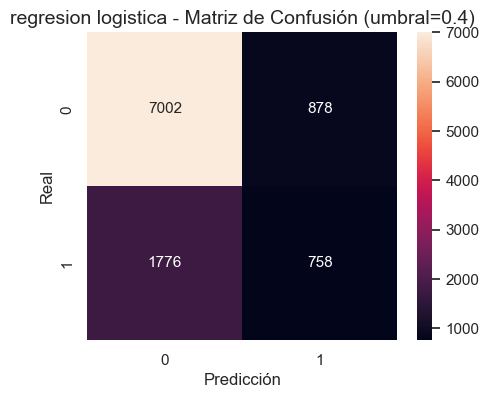

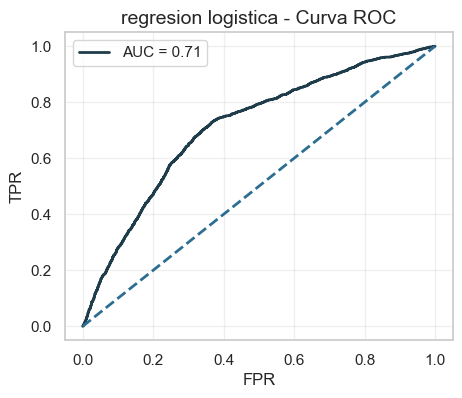

Accuracy:  0.745
Precision: 0.463
Recall:    0.299
F1-score:  0.364
ROC AUC:   0.712


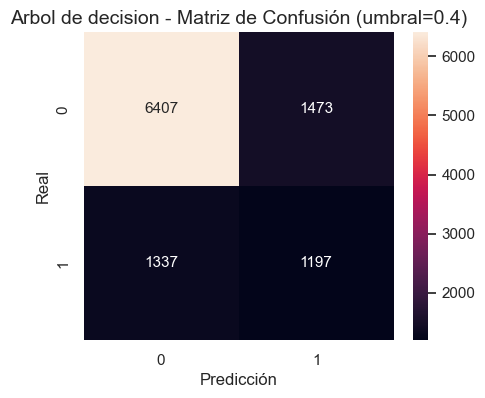

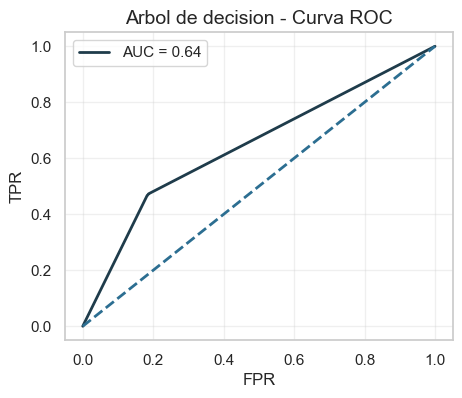

Accuracy:  0.730
Precision: 0.448
Recall:    0.472
F1-score:  0.460
ROC AUC:   0.643


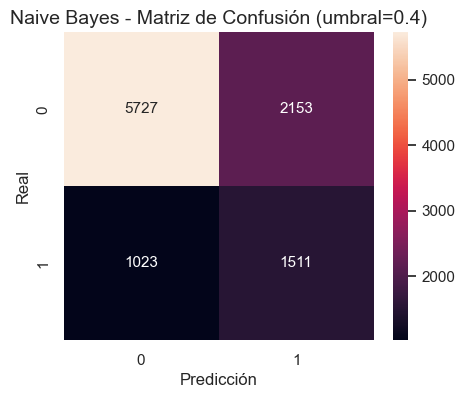

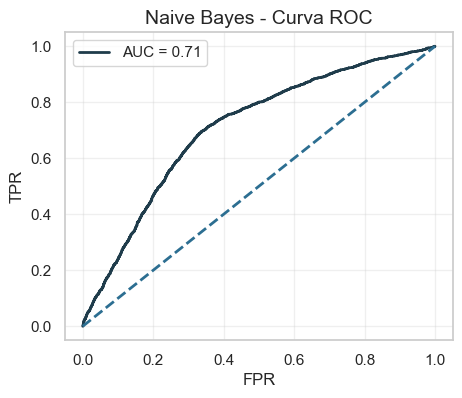

Accuracy:  0.695
Precision: 0.412
Recall:    0.596
F1-score:  0.488
ROC AUC:   0.708


C:\Users\maita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


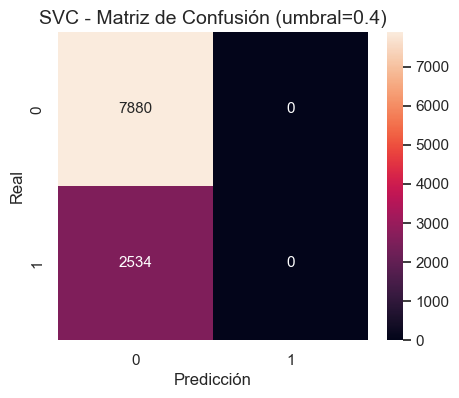

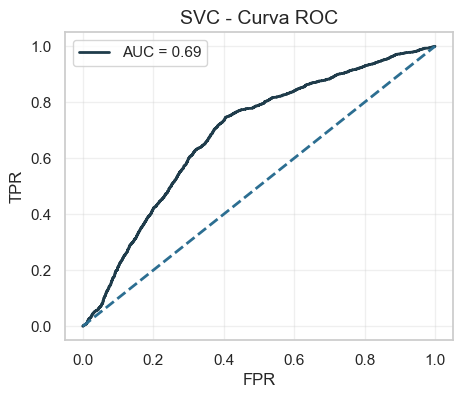

Accuracy:  0.757
Precision: 0.000
Recall:    0.000
F1-score:  0.000
ROC AUC:   0.686


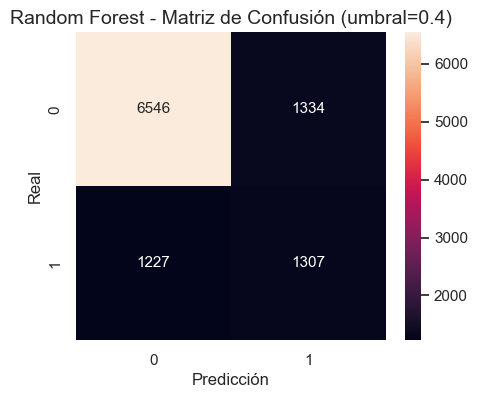

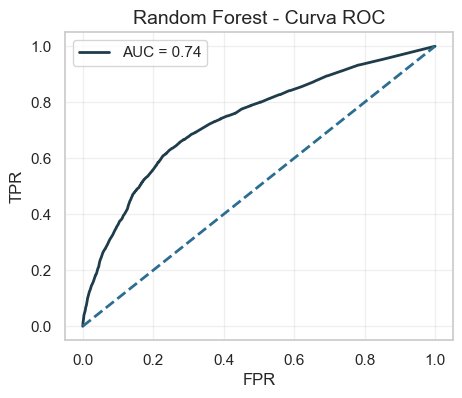

Accuracy:  0.754
Precision: 0.495
Recall:    0.516
F1-score:  0.505
ROC AUC:   0.736


(array([1.  , 0.65, 0.34, ..., 0.03, 0.08, 0.06], shape=(10414,)),
 array([1, 1, 0, ..., 0, 0, 0], shape=(10414,)))

In [ ]:
fm.evaluar_modelo(regresion_logistica, X_test=X_test_pca, 
               y_test=y_test, nombre_modelo='regresion logistica',
                umbral = 0.4 ) # pasamos test pca porque el modelo a aprendido con esos parametros
fm.evaluar_modelo(arbol_decision, X_test=X_test_pca, 
               y_test=y_test, nombre_modelo='Arbol de decision',
                umbral = 0.4 )
fm.evaluar_modelo(naive_bayes, X_test=X_test_pca, 
               y_test=y_test, nombre_modelo='Naive Bayes',
                umbral = 0.4 )
fm.evaluar_modelo(svc, X_test=X_test_pca, 
               y_test=y_test, nombre_modelo='SVC',
                umbral = 0.4)
fm.evaluar_modelo(random_forest, X_test=X_test_pca, 
               y_test=y_test, nombre_modelo='Random Forest',
                umbral = 0.4)

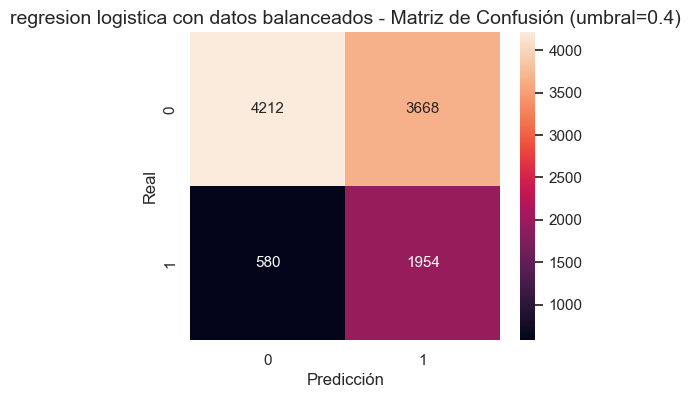

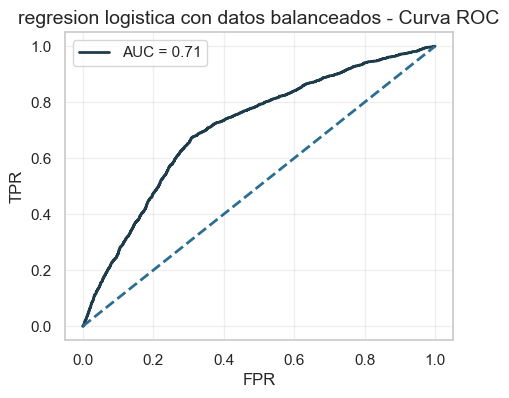

Accuracy:  0.592
Precision: 0.348
Recall:    0.771
F1-score:  0.479
ROC AUC:   0.709


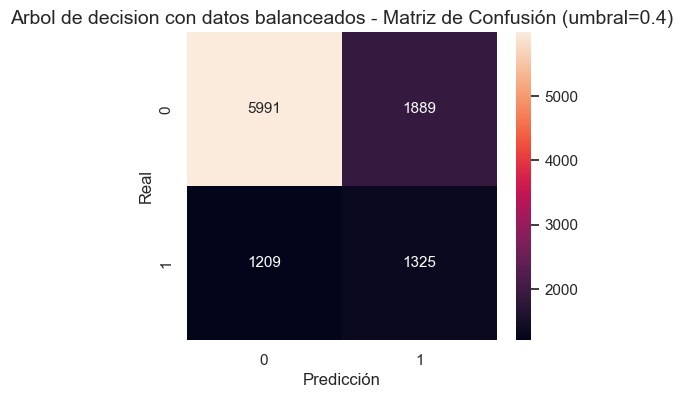

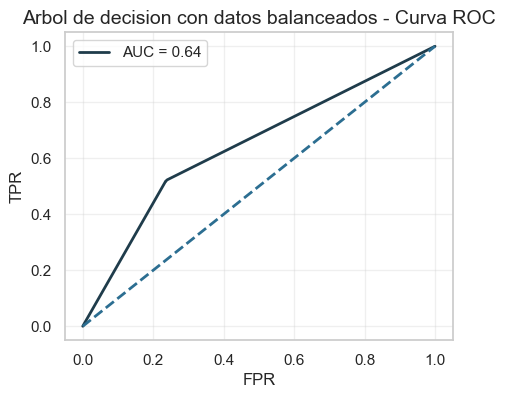

Accuracy:  0.703
Precision: 0.412
Recall:    0.523
F1-score:  0.461
ROC AUC:   0.642


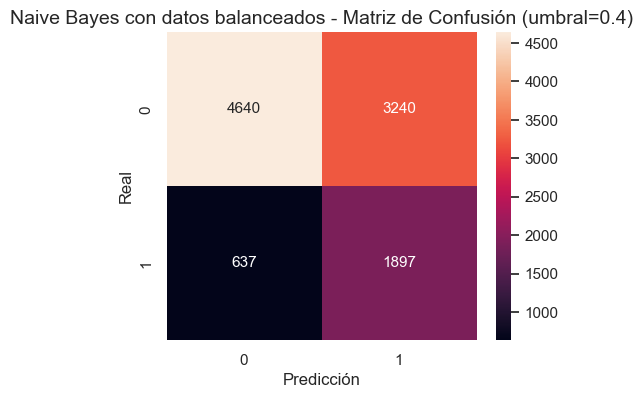

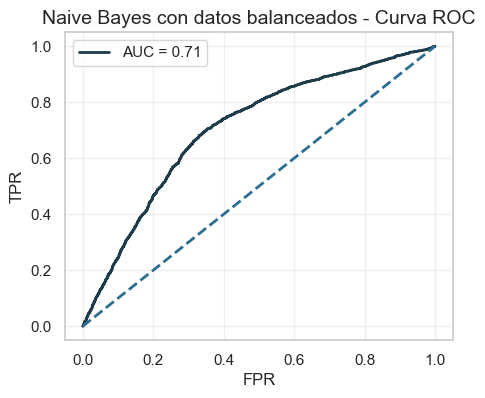

Accuracy:  0.628
Precision: 0.369
Recall:    0.749
F1-score:  0.495
ROC AUC:   0.705


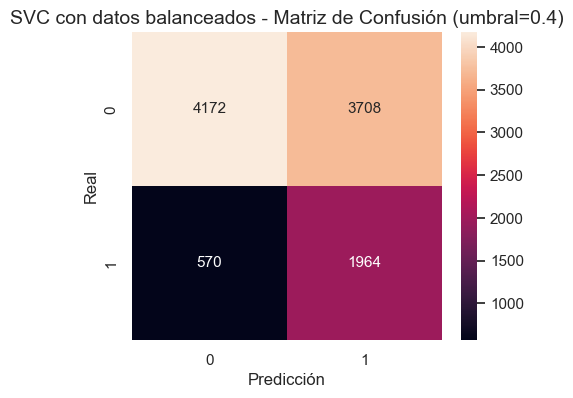

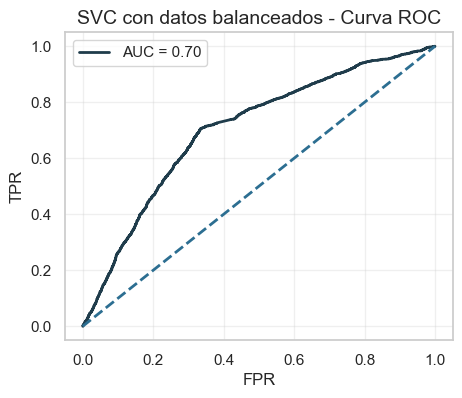

Accuracy:  0.589
Precision: 0.346
Recall:    0.775
F1-score:  0.479
ROC AUC:   0.703


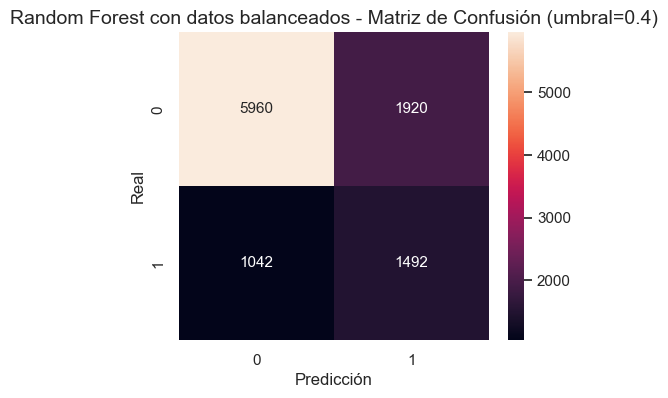

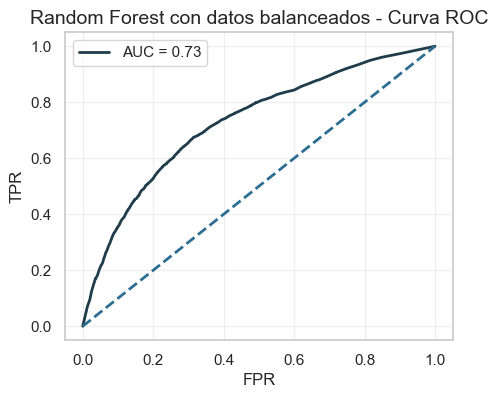

Accuracy:  0.716
Precision: 0.437
Recall:    0.589
F1-score:  0.502
ROC AUC:   0.728


(array([0.99, 0.82, 0.48, ..., 0.07, 0.  , 0.08], shape=(10414,)),
 array([1, 1, 1, ..., 0, 0, 0], shape=(10414,)))

In [44]:
fm.evaluar_modelo(regresion_logistica_smote, X_test=X_test_pca_smote, 
               y_test=y_test, nombre_modelo='regresion logistica con datos balanceados',
                umbral = 0.4 ) # pasamos test pca porque el modelo a aprendido con esos parametros (los datos de test de smote no estan balanceados, aunque no se llamen igual son los mismos que no balanceados)
fm.evaluar_modelo(arbol_decision_smote, X_test=X_test_pca_smote, 
               y_test=y_test, nombre_modelo='Arbol de decision con datos balanceados',
                umbral = 0.4 )
fm.evaluar_modelo(naive_bayes_smote, X_test=X_test_pca_smote, 
               y_test=y_test, nombre_modelo='Naive Bayes con datos balanceados',
                umbral = 0.4 )
fm.evaluar_modelo(svc_smote, X_test=X_test_pca_smote, 
               y_test=y_test, nombre_modelo='SVC con datos balanceados',
                umbral = 0.4)
fm.evaluar_modelo(random_forest_smote, X_test=X_test_pca_smote, 
               y_test=y_test, nombre_modelo='Random Forest con datos balanceados',
                umbral = 0.4)

TABLA COMPARATIVA CON TODAS LAS METRICAS CON LA FUNCION DE FUNCIONES_MODELADO

In [ ]:
# Diccionario con todos tus modelos
modelos_normal = {
    "Regresion_Logistica": regresion_logistica,
    "Arbol_Decision": arbol_decision,
    "Naive_Bayes": naive_bayes,
    "SVC": svc,
    "Random_Forest": random_forest
}
modelos_smote = {
    "Regresion_Logistica_SMOTE": regresion_logistica_smote,
    "Arbol_Decision_SMOTE": arbol_decision_smote,
    "Naive_Bayes_SMOTE": naive_bayes_smote,
    "SVC_SMOTE": svc_smote,
    "Random_Forest_SMOTE": random_forest_smote}


tabla_umbral_04_normal_TEST = fm.tabla_comparativa_modelos(modelos_normal, X_test_pca, y_test, umbral=0.4)
print(tabla_umbral_04_normal_TEST) 
tabla_umbral_04_smote_TEST =  fm.tabla_comparativa_modelos(modelos_smote, X_test_pca_smote, y_test, umbral=0.4)
print(tabla_umbral_04_smote_TEST)

                     Accuracy  Precision    Recall  F1-score   ROC AUC
Modelo                                                                
Regresion_Logistica  0.745151   0.463325  0.299132  0.363549  0.711524
Arbol_Decision       0.730171   0.448315  0.472376  0.460031  0.643409
Naive_Bayes          0.695026   0.412391  0.596290  0.487577  0.707795
SVC                  0.756674   0.000000  0.000000  0.000000  0.686425
Random_Forest        0.754081   0.494888  0.515785  0.505121  0.735531
                           Accuracy  Precision    Recall  F1-score   ROC AUC
Modelo                                                                      
Regresion_Logistica_SMOTE  0.592088   0.347563  0.771113  0.479156  0.708522
Arbol_Decision_SMOTE       0.702516   0.412259  0.522889  0.461030  0.642128
Naive_Bayes_SMOTE          0.627713   0.369282  0.748619  0.494590  0.705058
SVC_SMOTE                  0.589207   0.346262  0.775059  0.478674  0.703039
Random_Forest_SMOTE        0.715575   0.4

COMO REGRESION LOGISTICA CON DATOS BALANCEADOS ES EL MEJOR VAMOS A TRATAR DE MEJORAR METRICAS CAMBIANDO PARAMETROS

In [32]:
def buscar_mejores_parametros(X, y):
    """
    Función que devuelve el mejor modelo de regresión logística
    usando GridSearchCV con varios hiperparámetros.
    
    X: features de entrada
    y: etiquetas
    """
    # Definir el pipeline
    pipeline = Pipeline([
        ('clf', LogisticRegression())
    ])
    
    # Definir el grid de parámetros a probar
    parametros = {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # l1, l2 y elasticnet son comunes
        'clf__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
        'clf__max_iter': [100, 500, 1000]
    }
    
    # Configurar GridSearchCV
    grid = GridSearchCV(pipeline, parametros, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Entrenar y buscar los mejores parámetros
    grid.fit(X, y)
    
    print("Mejores parámetros encontrados:")
    print(grid.best_params_)
    
    return grid.best_estimator_



In [34]:
mejor_modelo_reg = buscar_mejores_parametros(X_train_smote_pca, y_train_smote_pca)

C:\Users\maita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
750 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\maita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\maita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

Mejores parámetros encontrados:
{'clf__C': 100, 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'saga'}


Matriz para poner en el informe: ponemos paleta de color unificada

In [36]:

cmap_hospitality = LinearSegmentedColormap.from_list(
    "hospitality",
    palette_hospitality
)


=== Evaluación en TRAIN ===


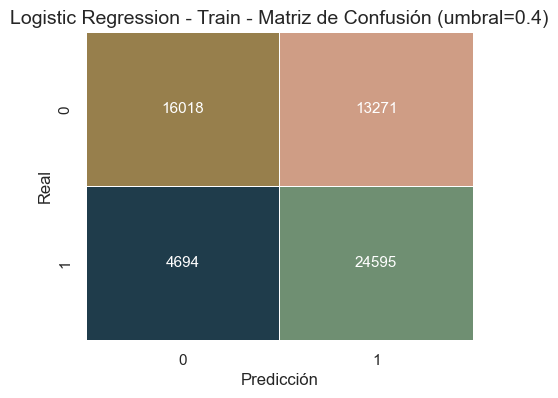

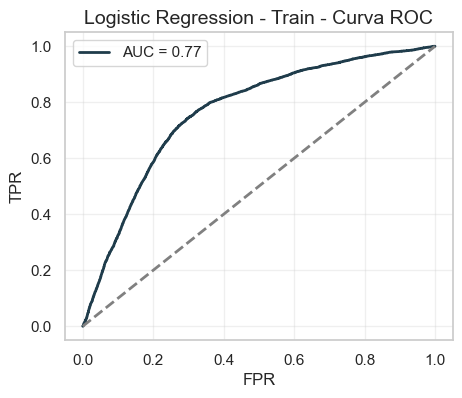

Logistic Regression - Train Metrics:
Accuracy: 0.693
Precision: 0.650
Recall: 0.840
F1-score: 0.732
ROC AUC: 0.765
=== Evaluación en TEST ===


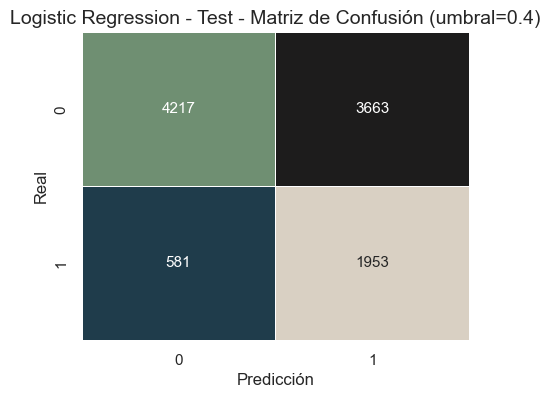

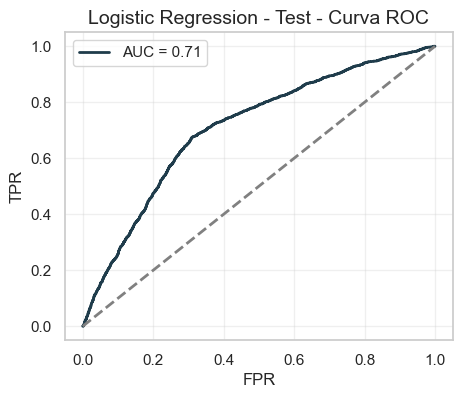

Logistic Regression - Test Metrics:
Accuracy: 0.592
Precision: 0.348
Recall: 0.771
F1-score: 0.479
ROC AUC: 0.709


(array([0, 1, 0, ..., 0, 0, 1], shape=(10414,)),
 array([0.28239189, 0.76390495, 0.28426265, ..., 0.25576108, 0.18591759,
        0.6995747 ], shape=(10414,)))

In [38]:
# Función para evaluar e imprimir métricas y gráficas
def evaluar(modelo, X, y, nombre="Modelo", umbral=0.4):
    # Obtener probabilidades
    if hasattr(modelo, "predict_proba"):
        y_prob = modelo.predict_proba(X)[:, 1]
    else:
        y_prob = modelo.decision_function(X)
        den = y_prob.max() - y_prob.min()
        y_prob = (y_prob - y_prob.min()) / den if den != 0 else y_prob

    # Predicciones según el umbral
    y_pred = (y_prob >= umbral).astype(int)

    # Métricas
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y, y_prob)

    # Matriz de confusión
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap_hospitality,   # 👈 aquí está la clave
        cbar=False,              # opcional, suele verse más limpio
        linewidths=0.5,
        linecolor="white"
    )
    plt.title(f"{nombre} - Matriz de Confusión (umbral={umbral})")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    # plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.title(f"{nombre} - Curva ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    # Imprimir métricas
    print(f"{nombre} Metrics:")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-score: {f1:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")

    return y_pred, y_prob

# Evaluar en entrenamiento
print("=== Evaluación en TRAIN ===")
evaluar(mejor_modelo_reg, X_train_smote_pca, y_train_smote_pca, nombre="Logistic Regression - Train")

# Evaluar en test
print("=== Evaluación en TEST ===")
evaluar(mejor_modelo_reg, X_test_pca_smote, y_test, nombre="Logistic Regression - Test")


In [ ]:
joblib.dump(mejor_modelo_reg, "mejor_modelo_reg.pkl")

['mejor_modelo_reg.pkl']

### Cargamos modelo de regresion para sacar coeficientes y ver la importancia de cada variable

In [33]:
mejor_modelo_reg = joblib.load("mejor_modelo_reg.pkl")
mejor_modelo_reg

FileNotFoundError: [Errno 2] No such file or directory: 'mejor_modelo_reg.pkl'

Como antes hemos aplicado PCA no podemos obtener la importancia de las variables directamente; por eso:

1. Obtenemos coeficientes del modelo en espacio PCA  (que nos dara la improtancia APROXIMADA de las variables --> es suficiente para interpretacion) y tambien obtenemos ODDS RATIO: 

OR > 1 → aumenta la probabilidad de la clase positiva

OR < 1 → la disminuye

OR = 1 → no tiene efecto

In [54]:
type(mejor_modelo_reg)
mejor_modelo_reg



,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,penalty,'l1'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None


Como es un pipeline (hemos guardado el modelo con los mejores parametros para no tener que estar cargando continuemente y agilizar el proceso), hacemos asi: 

In [61]:
# Acceder a PCA dentro del pipeline
# Obtener pipeline final
reg_log_model = mejor_modelo_reg.named_steps['clf'] # CARGAMOS DESDE EL PIPELINE QUE HEMOS GUARDADO ANTES PARA QUE NO TENER QUE ESTAR CARGANDO LOS MODELOS CONTINUAMENTE, SINO HACER ASI:


# Coeficientes sobre componentes PCA
coef_pca = reg_log_model.coef_[0] # Estos coeficientes corresponden a los COMPONENTES PRINCIPALES, no a las variables originale

# Pesos de cada componente sobre variables originales
componentes = pca_obj_smote.components_

# Aproximación importancia variables originales
importancia_original = np.dot(coef_pca, componentes) # Proyecta los coeficientes del modelo desde el espacio PCA al espacio original Y obtiene Un coeficiente aproximado por variable original

# Odss ratio
odds_ratio_pca = np.exp(coef_pca)
odds_ratio_original = np.exp(importancia_original)


odds_ratio_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef_aprox': importancia_original,
    'odds_ratio_aprox': odds_ratio_original
}).sort_values(by='odds_ratio_aprox', key=lambda x: abs(np.log(x)), ascending=False)

print(odds_ratio_df.head(20))

# intercepto
# Intercepto exacto en PCA
intercepto_pca = reg_log_model.intercept_[0]

# Media de las variables originales escaladas
media_variables = X_train.mean(axis=0).values

# Intercepto aproximado en variables originales
intercepto_original_aprox = intercepto_pca - np.dot(importancia_original, media_variables)

print("Intercepto PCA (exacto):", intercepto_pca)
print("Intercepto aproximado en variables originales:", intercepto_original_aprox)



                                   feature  coef_aprox  odds_ratio_aprox
61                rate_type_Non Refundable   -1.796545          0.165871
26                   origin_direct_channel   -0.855998          0.424859
5                         libere_community   -0.707959          0.492649
4                     returning_inhabitant   -0.625606          0.534937
25                   checkin_day_Wednesday   -0.206125          0.813732
24                     checkin_day_Tuesday   -0.135132          0.873601
21                    checkin_day_Saturday    0.127631          1.136134
33               requested_category_Studio    0.122729          1.130578
54     business_segment_Leisure Individual   -0.121277          0.885789
65                            city_Córdoba   -0.121082          0.885961
41  asset_Líbere Córdoba Patio Santa Marta   -0.121082          0.885961
13                      checkin_month_July   -0.114304          0.891987
10                  checkin_month_December    0.114

### Graficos


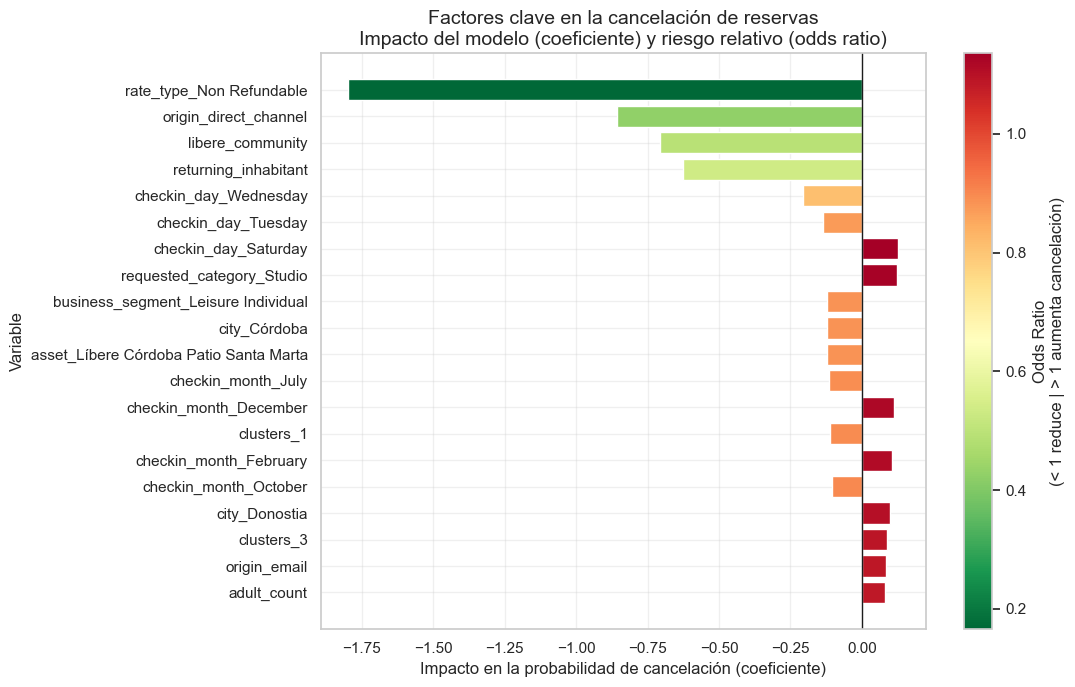

In [ ]:
# Preparar datos
df = odds_ratio_df.copy()
df["abs_coef"] = df["coef_aprox"].abs()

df = df.sort_values("abs_coef", ascending=False).head(20)
df = df.sort_values("abs_coef", ascending=True)

# Normalización del Odds Ratio para el color
norm = Normalize(
    vmin=df["odds_ratio_aprox"].min(),
    vmax=df["odds_ratio_aprox"].max()
)
cmap = plt.cm.RdYlGn_r
colors = cmap(norm(df["odds_ratio_aprox"]))

# Crear figura y eje EXPLÍCITOS
fig, ax = plt.subplots(figsize=(11, 7))

# Gráfico
ax.barh(
    df["feature"],
    df["coef_aprox"],
    color=colors
)

ax.axvline(0, color="#1C1C1C", linewidth=1)

ax.set_title(
    "Factores clave en la cancelación de reservas\n"
    "Impacto del modelo (coeficiente) y riesgo relativo (odds ratio)",
    fontsize=14
)
ax.set_xlabel("Impacto en la probabilidad de cancelación (coeficiente)")
ax.set_ylabel("Variable")

# Colorbar ASOCIADA AL AXIS
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Odds Ratio\n(< 1 reduce | > 1 aumenta cancelación)")

plt.tight_layout()
plt.show()


